a Sanford Health dataset that represents the ED (Emergency Department) volumes presenting to 4 Sanford Health medical centers 1/1/18 through 8/31/2025.
The dataset provides the facility, date, hour, reason, number of total encounters, number of those encounters admitted to a floor.

Forecast the future daily volumes (number of total encounters and the number of encounters admitted to a floor) for the month of September and October CY2025 (where CY means calendar year), by day.

# Basic things

In [3]:
# pip install polars

In [4]:
import polars as pl

df = pl.read_csv("DSU-Dataset.csv")

In [5]:
df.head()

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,str,f64,str,i64,i64
"""A""","""2018-01-01""",0.0,"""BREATHING PROBLEM""",1,1
"""A""","""2018-01-01""",0.0,"""BURN""",1,0
"""A""","""2018-01-01""",0.0,"""SHAKING""",1,1
"""A""","""2018-01-01""",0.0,"""VOMITING""",1,0
"""A""","""2018-01-01""",1.0,"""FROSTBITE""",1,0


In [6]:
col = df["Date"].str.to_date()
df = df.with_columns(col)

In [7]:
df.describe()

statistic,Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,str,str,f64,str,f64,f64
"""count""","""1174310""","""1174310""",1.17431e6,"""1168105""",1.17431e6,1.17431e6
"""null_count""","""0""","""0""",0.0,"""6205""",0.0,0.0
"""mean""",null,"""2021-12-05 23:13:59.314320""",13.549324,null,1.084646,0.291522
"""std""",null,null,6.142173,null,0.322814,0.47727
"""min""","""A""","""2018-01-01""",0.0,"""ABDOMINAL AORTIC ANEURYSM""",1.0,0.0
"""25%""",null,"""2019-12-23""",10.0,null,1.0,0.0
"""50%""",null,"""2021-12-30""",14.0,null,1.0,0.0
"""75%""",null,"""2023-11-11""",19.0,null,1.0,1.0
"""max""","""D""","""2025-08-31""",23.0,"""WRIST PAIN""",8.0,5.0


The forecasted volumes are not to be broken down by reason of visit.

In [8]:
import numpy as np

columns = df.columns

for col in columns:
    print(f"Column {col} has {df[col].is_null().sum()} missing values.")

print(f"ED Enc has a min of {df['ED Enc'].min()} and a max of {df['ED Enc'].max()} at a particular hour for a certain reason")
print(f"ED Enc Admitted has a min of {df['ED Enc Admitted'].min()} and a max of {df['ED Enc Admitted'].max()} at a particular hour for a certain reason")
print(f"There are sites: {', '.join([site for site in df['Site'].unique()])}")

Column Site has 0 missing values.
Column Date has 0 missing values.
Column Hour has 0 missing values.
Column REASON_VISIT_NAME has 6205 missing values.
Column ED Enc has 0 missing values.
Column ED Enc Admitted has 0 missing values.
ED Enc has a min of 1 and a max of 8 at a particular hour for a certain reason
ED Enc Admitted has a min of 0 and a max of 5 at a particular hour for a certain reason
There are sites: C, B, A, D


# Trends in months

Combine encounters by months, then facilities. See trends over months

In [9]:
start_date = df["Date"].min()
end_date = df["Date"].max()
month_date_range = pl.date_range(start=start_date, end=end_date, interval="1mo",  eager=True)

monthly_site_data = df.clear().drop(["Date", "Hour", "REASON_VISIT_NAME"]).with_columns([pl.lit(0).alias("Year").cast(pl.Int32), pl.lit(0).alias("Month").cast(pl.Int32)])
# rearranging columns
monthly_site_data = monthly_site_data.select(["Site", "Year", "Month", "ED Enc", "ED Enc Admitted"])
monthly_data = monthly_site_data.clear().drop("Site")

for single_date in month_date_range.to_list():
    # get the data for the specific month
    filter_monthly = df.filter(
        (pl.col("Date").dt.month() == single_date.month) & (pl.col("Date").dt.year() == single_date.year)
    )

    month_data = pl.DataFrame({
        "Year": single_date.year,
        "Month": single_date.month,
        "ED Enc": filter_monthly.select(pl.col("ED Enc")).sum(),
        "ED Enc Admitted": filter_monthly.select(pl.col("ED Enc Admitted")).sum(),
    })

    monthly_data = pl.concat([monthly_data, month_data])

    for site in ['A', 'B', 'C', 'D']:
        month_site_data = pl.DataFrame({
                        "Site": site,
                        "Year": single_date.year,
                        "Month": single_date.month,
                        "ED Enc": filter_monthly.filter(pl.col("Site") == site).select(pl.col("ED Enc")).sum(),
                        "ED Enc Admitted": filter_monthly.filter(pl.col("Site") == site).select(pl.col("ED Enc Admitted")).sum()
                    })
        monthly_site_data = pl.concat([monthly_site_data, month_site_data])

print(monthly_site_data.head())
print(monthly_data.head())

shape: (5, 5)
┌──────┬──────┬───────┬────────┬─────────────────┐
│ Site ┆ Year ┆ Month ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---  ┆ ---   ┆ ---    ┆ ---             │
│ str  ┆ i32  ┆ i32   ┆ i64    ┆ i64             │
╞══════╪══════╪═══════╪════════╪═════════════════╡
│ A    ┆ 2018 ┆ 1     ┆ 3888   ┆ 1182            │
│ B    ┆ 2018 ┆ 1     ┆ 4944   ┆ 1150            │
│ C    ┆ 2018 ┆ 1     ┆ 2621   ┆ 830             │
│ D    ┆ 2018 ┆ 1     ┆ 2204   ┆ 358             │
│ A    ┆ 2018 ┆ 2     ┆ 3558   ┆ 1004            │
└──────┴──────┴───────┴────────┴─────────────────┘
shape: (5, 4)
┌──────┬───────┬────────┬─────────────────┐
│ Year ┆ Month ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---   ┆ ---    ┆ ---             │
│ i32  ┆ i32   ┆ i64    ┆ i64             │
╞══════╪═══════╪════════╪═════════════════╡
│ 2018 ┆ 1     ┆ 13657  ┆ 3520            │
│ 2018 ┆ 2     ┆ 12232  ┆ 3087            │
│ 2018 ┆ 3     ┆ 13101  ┆ 3347            │
│ 2018 ┆ 4     ┆ 12842  ┆ 3307            │
│ 2018 ┆ 5     

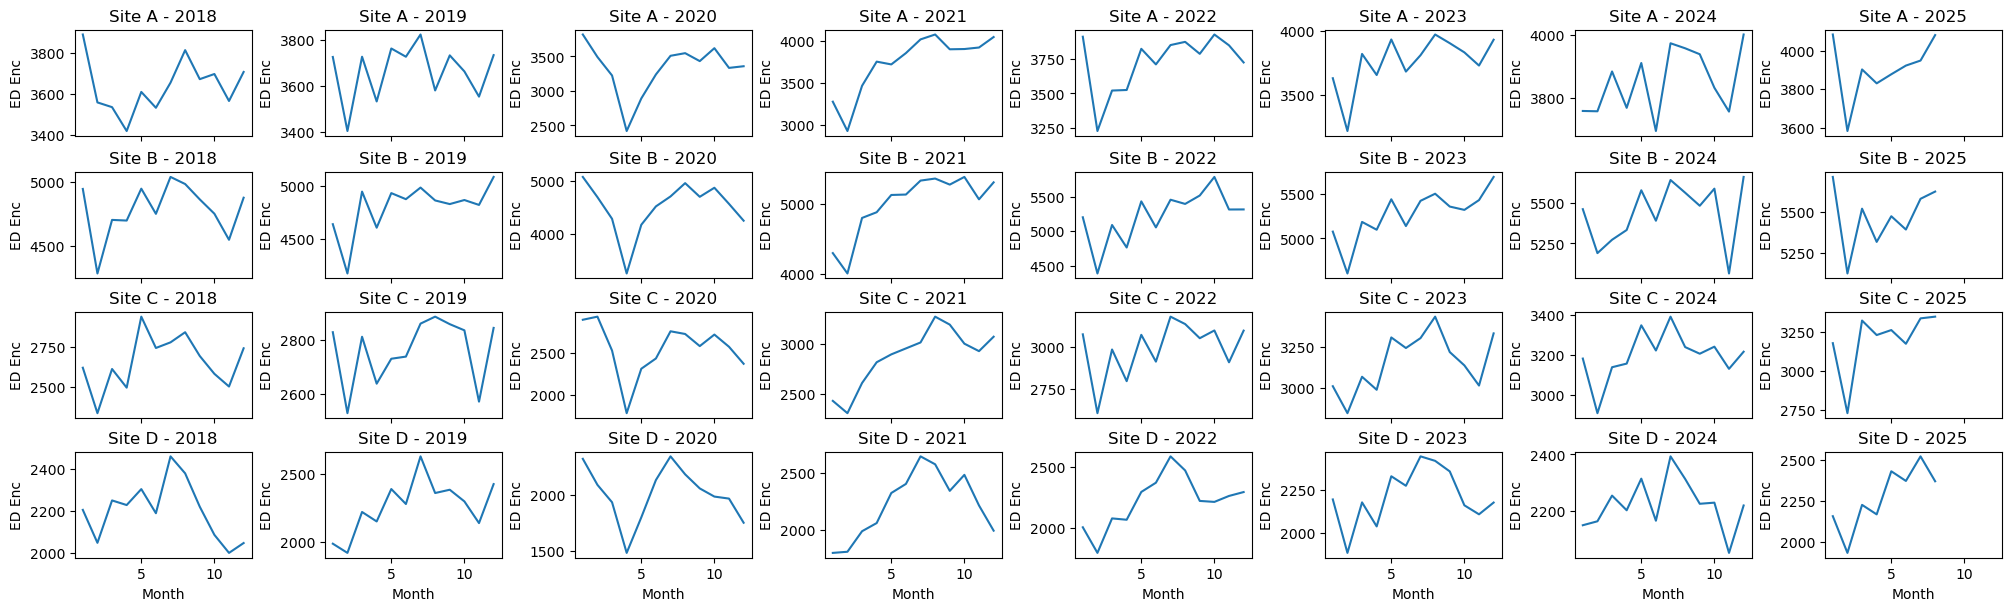

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# for each year (2018-2025), create a line plot of monthly ED Enc for each site
# 8 years, 4 sites
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=True)

for i, year in enumerate(range(2018, 2026)):
    for j, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=monthly_site_data.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Month', y='ED Enc', ax=axes[j, i])
        axes[j, i].set_title(f'Site {site} - {year}')
        axes[j, i].set_xlabel('Month')
        axes[j, i].set_ylabel('ED Enc')

plt.show()


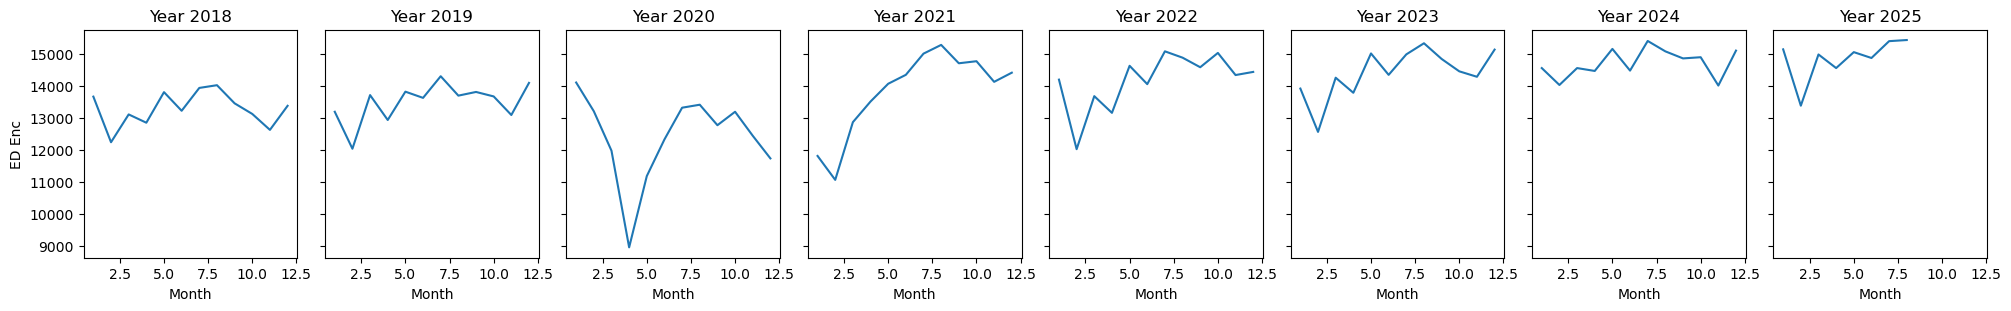

In [10]:
fig, axes = plt.subplots(1, 8, layout="constrained", figsize=(20, 3), sharex=True, sharey=True)

for i, year in enumerate(range(2018, 2026)):
    sns.lineplot(data=monthly_data.filter(pl.col('Year') == year),
                    x='Month', y='ED Enc', ax=axes[i])
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('ED Enc')

plt.show()